# Practical Session 4 -  Atlas estimation

In shape analysis, an atlas is formed of a template shape, that captures common features of all subjects, together with a set of deformations between template and individuals. Deformations should transcribe shape variability among populations.

Here you will see the deterministic atlas, the basic one. But there exists other atlas models, as bayesian atlas.


This practical session is mainly based on LDDMM algorithm, that you saw in the previous practical session.

In [1]:
import numpy as np
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import torch 

%matplotlib inline
tensor_type = torch.DoubleTensor

import os 
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Import data

In this practical session, images will be a set of digits, to register from a template digit.
There are 20 digits, but you should test your algorithm on a sample of the set to confirm it's working.

In [2]:
dico_images = {}
for i in range(1,21):
    dico_images[i] = np.array(mpimg.imread("./Images/digits/digit_2_sample_{}.png".format(i))) 
digit_template =  np.array(mpimg.imread("./Images/digits/digit_2_mean.png")) 

# subset_digits = {1:dico_images[1],2:dico_images[2],3:dico_images[3]} 

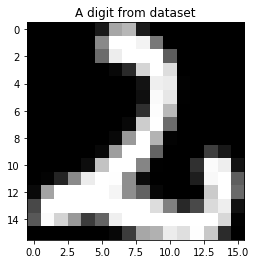

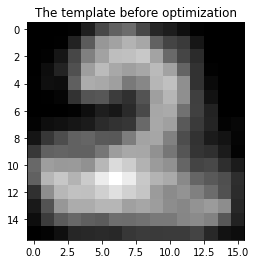

In [3]:
plt.imshow(dico_images[1],cmap='gray')
plt.title('A digit from dataset')
plt.show()

plt.imshow(digit_template,cmap='gray')
plt.title('The template before optimization')
plt.show()

# Functions

In [4]:
def _swap_colums(ar, i, j):
    aux = np.copy(ar[:, i])
    ar[:, i] = np.copy(ar[:, j])
    ar[:, j] = np.copy(aux)
    return np.copy(ar)



def interpolate_image(intensities, deformed_pixels, padding_width=1):
    '''
    This function, given original image in intensities tensor, 
    deformed pixels : coordinates of registered pixels in original image 
    returns the final registered image in deformed_intensities
    ------- 
    intensities : (nr,nc)
    deformed_pixels : (nr*nc,d)
    -------
    returns registered image in deformed_intensities, of shape (nr,nc) in a tensor 
    '''
    
    padding_color = 1.
    if intensities.ndim == 2:
        i,j = intensities.size()
        k = 1
        intensities_cp = intensities[...,np.newaxis]
    else :
        i,j,k = intensities.size()
        intensities_cp = intensities
        
    deformed_pixels += torch.from_numpy(np.array([float(padding_width), float(padding_width)])).view(1, 2).expand(i*j, 2).type(torch.DoubleTensor)

    padded_intensities = torch.ones((i + 2 * padding_width, j + 2 * padding_width, k)).type(torch.DoubleTensor) * padding_color
    padded_intensities[padding_width:padding_width + i, padding_width:padding_width + j] = intensities_cp

    u, v = deformed_pixels[:, 0], deformed_pixels[:, 1]

    u1 = torch.floor(u)
    v1 = torch.floor(v)

    u1 = torch.clamp(u1, 0, i - 1 + 2 * padding_width)
    v1 = torch.clamp(v1, 0, j - 1 + 2 * padding_width)
    u2 = torch.clamp(u1 + 1, 0, i - 1 + 2 * padding_width)
    v2 = torch.clamp(v1 + 1, 0, j - 1 + 2 * padding_width)

    fu = (u - u1).view(i * j, 1).expand(i*j, k)
    fv = (v - v1).view(i * j, 1).expand(i*j, k)
    gu = ((u1 + 1) - u).view(i * j, 1).expand(i*j, k)
    gv = ((v1 + 1) - v).view(i * j, 1).expand(i*j, k)

    deformed_intensities = (padded_intensities[u1.type(torch.LongTensor), v1.type(torch.LongTensor)] * gu * gv +
                            padded_intensities[u1.type(torch.LongTensor), v2.type(torch.LongTensor)] * gu * fv +
                            padded_intensities[u2.type(torch.LongTensor), v1.type(torch.LongTensor)] * fu * gv +
                            padded_intensities[u2.type(torch.LongTensor), v2.type(torch.LongTensor)] * fu * fv).view(i, j, k)
    deformed_intensities = torch.clamp(deformed_intensities, 0., 1.)

    return deformed_intensities.reshape(intensities.size())



# Atlas estimation functions

In [5]:
def _differences(x, y):
    
    """ 
    x is of shape (n, 2)
    y is of shape (m, 2)
    --------
    returns the difference between each element of x and y in a (2,n,m) tensor
    
    """
    x_col = x.t().unsqueeze(2)  # (n,D=2) -> (D,n,1)
    y_lin = y.t().unsqueeze(1)  # (m,D) -> (D,1,m)
    return x_col - y_lin

def _squared_distances(x, y):
    
    """ 
    x is of shape (n, 2)
    y is of shape (m, 2)
    
    --------
    returns the squared euclidean distance between each element of x and y in a (n,m) tensor
    
    """
    
    x_norm = (x ** 2).sum(1).view(-1, 1)
    y_norm = (y ** 2).sum(1).view(1, -1)

    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))
    return dist


def gaussian_kernel(x, y, kernel_width):
    """ 
    x is of shape (n, 2)
    y is of shape (m, 2)
    kernel_width is a value
    
    --------
    returns the gaussian kernel value between each element of x and y in a (n,m) tensor
    
    """

    squared_dist = _squared_distances(x, y)
    return torch.exp(- squared_dist / kernel_width **2 )

def h_gradx(cp, alpha, kernel_width):
    
    '''
    This function computes derivative of the kernel for each couple (cp_i,alpha_i), with cp_i a control point(landmark).
    ---------
    
    cp is of shape (n_landmarks, 2)
    alpha is of shape (n_landmarks, 2)
    kernel_width is a value
    
    --------
    returns a tensor of shape (n_landmarks, 2)
    '''
    
    sq = _squared_distances(cp, cp)
    A = torch.exp(-sq / kernel_width **2)
    B = _differences(cp, cp) * A
    
    return - 2 * B / (kernel_width ** 2)
    
    
def discretisation_step(cp, alpha, dt, kernel_width):
    
    '''
   
    This function computes a step of discretized equations for both alpha and control points on one step. 
    Compute here a displacement step  of control points an alpha, from discretized system seen in class.
    ---------
    
    cp is of shape (n_landmarks, 2)
    alpha is of shape (n_landmarks, 2)
    dt is your time step 
    kernel_width is a value
    
    --------
    
    returns resulting control point and alpha displacements in tensors of size (n_landmarks,2) both.
    
    '''

    res_cp = cp + dt * torch.matmul(gaussian_kernel(cp, cp, kernel_width), alpha)
    res_alpha = alpha - dt / 2.  * torch.sum(alpha * (torch.matmul(h_gradx(cp, alpha, kernel_width), alpha)), 2).t() 
    
    return res_cp, res_alpha



def shoot(cp, alpha, kernel_width, n_steps=10):
     
    """
    This is the trajectory of a Hamiltonian dynamic, with system seen in lecture notes. 
    Compute here trajectories of control points and alpha from t=0 to t=1.
    ------------
    cp is of shape (n_landmarks, 2)
    alpha is of shape (n_landmarks, 2)
    n_step : number of steps in your hamiltonian trajectory, use to define your time step
    kernel_width is a value
    --------
    returns traj_cp and traj_alpha trajectories of control points and alpha in lists. 
    The length of a list is equal to n_step. 
    In each element of the list, you have a tensor of size (n_landmarks,2) returned by discretisation_step() function.
    """
    
    
    traj_cp, traj_alpha = [], []
    traj_cp.append(cp)
    traj_alpha.append(alpha)
    dt = 1. / float(n_steps-1)
    
    for _ in range(n_steps-1):
        new_cp, new_alpha = discretisation_step(traj_cp[-1], traj_alpha[-1], dt, kernel_width)
        traj_cp.append(new_cp)
        traj_alpha.append(new_alpha)
        
    return traj_cp, traj_alpha

In [6]:
def register_points(traj_cp, traj_alpha, y, kernel_width):
    """
    This is the application of the computed trajectories on a set of points (landmarks or new points).
    ------------
    
    traj_cp is the list containing the trajectory of your landmarks 
    traj_alpha is is the list containing the trajectory of your alpha 
    y : points you want to register (landmarks or other points), size (n,2)
    kernel_width is a value
    
    --------
    
    returns traj_y,  the trajectory of points y, in a list of length n_step. 
    In each element of the list, you should have an array of dimension (n,2) (same dimensions as y)
    """
    
    # We now flow the points
    traj_y = [y]
    n_steps = len(traj_cp) - 1
    dt = 1. / float(n_steps)
    
    for i in range(n_steps):
        new_y = traj_y[-1] + dt * torch.matmul(gaussian_kernel(traj_y[-1], traj_cp[i], kernel_width), traj_alpha[i])
        traj_y.append(new_y)
    
    return traj_y

In [7]:
def register_image(traj_cp, traj_alpha, image, kernel_width):
    """
    This is the application of the computed trajectories on an image, by computation of inversed phi_1.
    ------------
    traj_cp is the list containing the trajectory of your landmarks 
    traj_alpha is the list containing the trajectory of your alpha 
    image : image to register, of size (nr,nc)
    kernel_width is a value
    --------
    returns the registered image, of same dimensions as image, (nr,nc)
    
    """
    
    if image.ndim==2:
        i,j = image.shape
        k = 1
    else :
        i,j,k = image.shape
        
    points = np.array(np.meshgrid(range(i), range(j)))
    points = np.swapaxes(points, 0, 2).reshape(i * j, 2) 
    points = torch.from_numpy(points).type(tensor_type)
    
    traj_cp_inverse = traj_cp[::-1]
    traj_alpha_inverse = [-1 * elt for elt in traj_alpha[::-1]]
    deformed_points = register_points(traj_cp_inverse, traj_alpha_inverse, points, kernel_width)[-1]
    
    return interpolate_image(image, deformed_points)

**Instructions : compute attachment and regularity between the template and each subject (each image).** \
\
Then, compute total attachment and total regularity.
The total cost function is already written at the end of the function (in `total` object).\
\
Data attachment is how well the collection of objects is fitted by the deformation of the template.\
Regularity acts as a regularizer by penalizing the kinetic energy of the deformations.

In [8]:
def compute_attachment_regularity_gradient(cp, alpha, template_data, subjects, kernel_width, gamma):
    '''
    TO DO
    ATTENTION : you only use torch tensors here, no numpy objects
    ---------- 
    This function compute attachments and regularities in order to compute the loss and optimize momenta and template with gradient descent.
    In order to do this, you have to deform the control points and the template as with LDDMM, for each image/subject.
    Then compute attachment and regularity for each pair of deformed template and points.
    And finally the total attachment and the total regularity.
    The total loss is already computed.
    ------ 
    cp : tensor (n_landmarks, 2) 
    alpha : tensor (n_landmarks, 2, n_images) 
    template_data : tensor (nr, nc) 
    subjects : tensor (nr, nc, n_images) 
    kernel_width and gamma : parameters, values
    ----- 
    returns 4 objects :
    total_attachement is a tensor with only one value inside, ex. tensor(10)
    total_regularity is a tensor with only one value inside, same
    deformed template according to each subject : tensor (nr,nc,n_images) 
    deformed control points according to each subject : tensor (n_landmarks,2,n_images)
    '''
    
    n_images = subjects.size()[2] 
    n_landmark = cp.size()[0] 
    nr = template_data.size()[0] 
    nc = template_data.size()[1] 
    
    trajectory_cp = [] 
    trajectory_alpha = [] 
    for i in range(n_images): 
        trajectory_cp.append([]) 
        trajectory_alpha.append([]) 
    
    deformed_template = torch.zeros(nr, nc, n_images) 
    deformed_control_points = torch.zeros(n_landmark, 2, n_images) 
    total_attachment = 0 
    total_regularity = 0 
    kernel = gaussian_kernel(cp, cp, kernel_width) 
    
    for i in range(n_images): 
        trajectory_cp[i], trajectory_alpha[i] = shoot(cp, alpha[:, :, i], kernel_width, n_steps = 10) 
        deformed_template[:, :, i] = register_image(trajectory_cp[i], trajectory_alpha[i], template_data, kernel_width) 
        deformed_control_points[:, :, i] = trajectory_cp[i][-1] 
        
        attachment = torch.norm(subjects[:, :, i] - deformed_template[:, :, i])**2 
        regularity = (torch.norm(torch.mm(torch.mm(torch.transpose(alpha[:,:,i], 0, 1),kernel),alpha[:,:,i]))**2) * gamma 
        
        total_attachment += attachment 
        total_regularity += regularity 
        
    #################
    ### Here is computed the total loss and its gradient with torch.backward()
    total = total_attachment + total_regularity
    total.backward() 
    return total_attachment.detach(), total_regularity.detach(), deformed_template.detach(), deformed_control_points.detach()

In [9]:
def atlas_learn_template(dico_images,niter,kernel_width,gamma,eps,template=None,landmarks=None):
    
    '''
    This is the main function, which computes gradient descent to minimize cost function,
    and find optimal trajectories for control points, alpha and deformed template.
    Take a dictionary with images, niter number of iterations, kernel_width and gamma parameters, eps for step size
    template and landmarks are optionals.
    -------
    returns 
    cp : deformation of  control points to match with each subject : numpy array (n_landmarks,2,n_images)
    alpha : optimized momenta,  numpy array (n_landmarks,2,n_images)
    template_data : the optimized template, numpy array (nr,nc) 
    deformed_template : deformation of template according to each image,  numpy array (nr,nc,n_images)

    '''

  
    ## Convert the dictionnary of images to a 3 dimensional array (nr,nc,n_images)
    
    Images = dico_images[1]
    for key, value in dico_images.items():
        if key==2:
            Images = np.stack((Images,value),axis=-1)   
        elif key !=1 :
            Images = np.concatenate((Images,value[...,np.newaxis]),axis=-1)   

    Images_base = torch.from_numpy(Images.copy()).type(tensor_type)
    
    
    ### Convert template, if given, to a tensor (nx,ny)
    ### If no template is provided, take the first image of set
    if template is None :
        template_data = torch.from_numpy(Images[...,0].copy()).type(tensor_type)  
    else :
        template_data = torch.from_numpy(template).type(tensor_type)
        
    #### Initialize control points
    #### Here, with digits database, no control points are provided, 
    #### So we build a regular grid with interval equals to kernel_width.
    #### You can plot control points to see where they are exactly.
    #### cp tensor is of  shape (n_landmarks,2) with y-axis coordinates in first column and x-axis coordinates in second column
    
    if landmarks is not None :
        cp = torch.from_numpy(landmarks1).type(tensor_type)
    else :
        cp = np.array(np.meshgrid(np.arange(0,template.shape[0]-2,kernel_width), np.arange(0,template.shape[1]-2,kernel_width)))
        cp = np.swapaxes(cp, 0, 2).reshape(-1, 2) 
        cp = torch.from_numpy(cp).type(tensor_type)
    
    ##### Plot template at the beginning and first original digits
    
    plt.figure()
    plt.subplot(1,5,1)
    plt.imshow(template_data.detach().numpy(),cmap='gray')
    plt.subplot(1,5,2)
    plt.imshow(np.clip(Images[...,0],0,1),cmap='gray')
    plt.subplot(1,5,3)
    plt.imshow(np.clip(Images[...,1],0,1),cmap='gray')
    plt.subplot(1,5,4)
    plt.imshow(np.clip(Images[...,2],0,1),cmap='gray')
    plt.subplot(1,5,5)
    plt.imshow(np.clip(Images[...,3],0,1),cmap='gray')
    plt.title('Template at the beginning and first four digits')
    plt.show()
      
    ##### Initialize momenta
    number_of_subjects = Images_base.size(-1)
    alpha = torch.zeros((cp.size(0),cp.size(1),number_of_subjects)).type(tensor_type)
    alpha.requires_grad_(True)
    template_data.requires_grad_(True)
    
    #######################    
    #### Iterations    
            
    for it in range(niter):
        
        current_attachment, current_regularity,deformed_template,deformed_points = compute_attachment_regularity_gradient(cp,alpha,template_data,Images_base,kernel_width,gamma)
  
        gradient = {}
        gradient['alpha'] = alpha.grad.detach()
        gradient['template_data'] = template_data.grad.detach()

        eps_mom = eps/np.sqrt(np.sum(gradient['alpha'].numpy() ** 2))
        eps_template = eps/np.sqrt(np.sum(gradient['template_data'].numpy() ** 2)+10**-5)
        
        with torch.no_grad():
            alpha -=   alpha.grad * eps_mom
            template_data -=   template_data.grad * eps_template
            
        alpha.grad.zero_()
        template_data.grad.zero_()
                                                                           
  
        attach_value = current_attachment.numpy()
        regul_value = current_regularity.numpy()

        if it % 20 == 0:
            print('------------------------------------- Iteration: ' + str(it)  + ' -------------------------------------')
            print(attach_value)
            print(regul_value)
        
   
            ##### Plot template and deformed template according to first digits

            plt.figure()
            plt.subplot(1,5,1)
            plt.imshow(np.clip(template_data.detach().numpy(),0,1),cmap='gray')
            plt.title('Template')
            plt.subplot(1,5,2)
            plt.imshow(np.clip(deformed_template.detach().numpy()[...,0],0,1),cmap='gray')
            plt.subplot(1,5,3)
            plt.imshow(np.clip(deformed_template.detach().numpy()[...,1],0,1),cmap='gray')
            plt.subplot(1,5,4)
            plt.imshow(np.clip(deformed_template.detach().numpy()[...,2],0,1),cmap='gray')
            plt.subplot(1,5,5)
            plt.imshow(np.clip(deformed_template.detach().numpy()[...,3],0,1),cmap='gray')
            plt.show()
    

    
    return cp.detach().numpy(),alpha.detach().numpy(),np.clip(template_data.detach().numpy(),0,1),deformed_template.detach().numpy()

# Execution

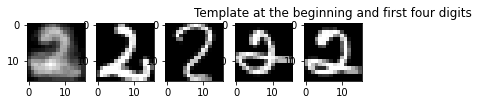

------------------------------------- Iteration: 0 -------------------------------------
551.2311479110336
0.0


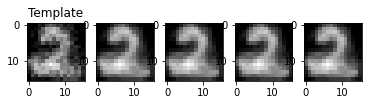

------------------------------------- Iteration: 20 -------------------------------------
227.44005504469146
38.04116794716105


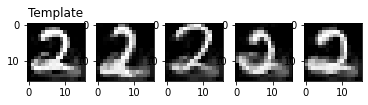

------------------------------------- Iteration: 40 -------------------------------------
190.48412157773885
47.24279557720199


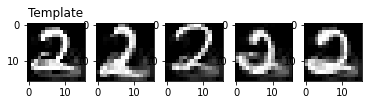

------------------------------------- Iteration: 60 -------------------------------------
180.2666675947501
51.83557187296285


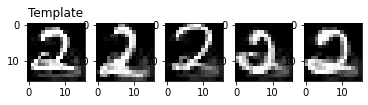

------------------------------------- Iteration: 80 -------------------------------------
171.00187809369305
53.95907018702285


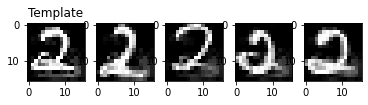

------------------------------------- Iteration: 100 -------------------------------------
159.78807204929325
54.989392141934744


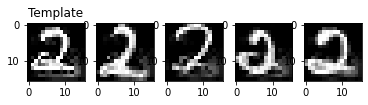

------------------------------------- Iteration: 120 -------------------------------------
163.2762043295001
55.20015325268884


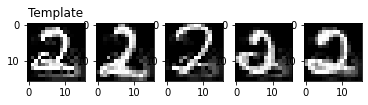

------------------------------------- Iteration: 140 -------------------------------------
148.76025304180308
57.02776280285177


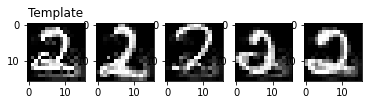

------------------------------------- Iteration: 160 -------------------------------------
157.96534157289523
56.728212842520925


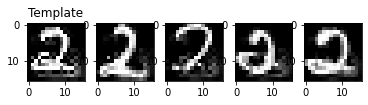

------------------------------------- Iteration: 180 -------------------------------------
148.53934982449294
57.75387288851533


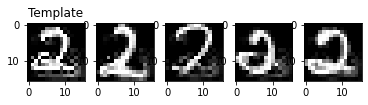

------------------------------------- Iteration: 200 -------------------------------------
146.68687587072787
56.725070317192255


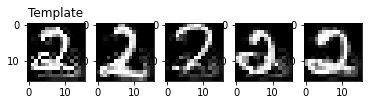

------------------------------------- Iteration: 220 -------------------------------------
149.8540547155244
56.92165862419177


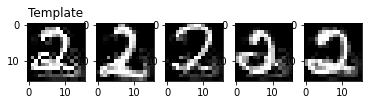

------------------------------------- Iteration: 240 -------------------------------------
150.52087449672447
57.20176256965997


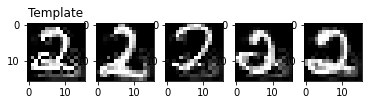

------------------------------------- Iteration: 260 -------------------------------------
150.66707316770112
56.74419361893511


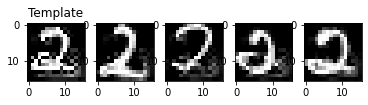

------------------------------------- Iteration: 280 -------------------------------------
145.21340657657936
58.65870379003448


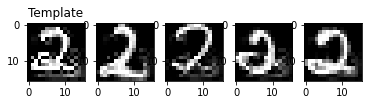

------------------------------------- Iteration: 300 -------------------------------------
146.01934843679217
57.04164800228265


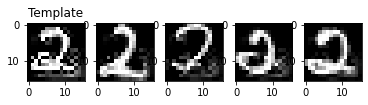

------------------------------------- Iteration: 320 -------------------------------------
151.4419150819102
57.26165201034097


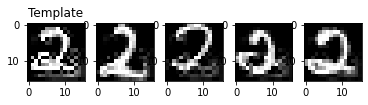

------------------------------------- Iteration: 340 -------------------------------------
150.76732219011785
57.27538899750914


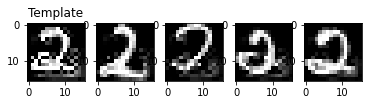

------------------------------------- Iteration: 360 -------------------------------------
144.71144906471642
57.81741133886881


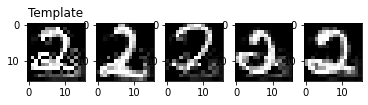

------------------------------------- Iteration: 380 -------------------------------------
143.14590755401684
59.46566658186631


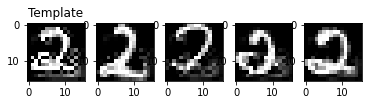

------------------------------------- Iteration: 400 -------------------------------------
145.43911597758634
57.14472490585727


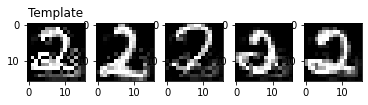

------------------------------------- Iteration: 420 -------------------------------------
144.27996920314445
57.758209948493516


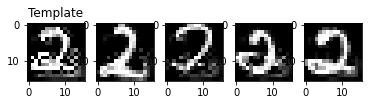

------------------------------------- Iteration: 440 -------------------------------------
147.40411244038413
57.67208335306282


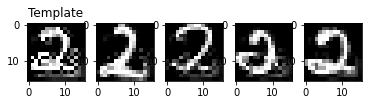

------------------------------------- Iteration: 460 -------------------------------------
141.0983095806603
59.49816093189932


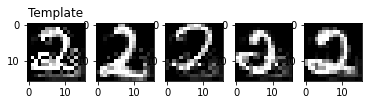

------------------------------------- Iteration: 480 -------------------------------------
148.18518472542002
57.022376085449345


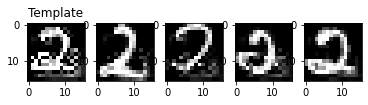

In [11]:
eps = 1 

#################
#### You are strongly advice to test different values of the parameters below.

kernel_width = 2.
niter = 500
gamma = 0.01


## Execution of the algorithm
control_points, momenta,optim_template,deformed_digits = atlas_learn_template(dico_images,niter,kernel_width,gamma,eps,template=digit_template,landmarks=None)


## Obtained template at the end of the atlas estimation algorithm

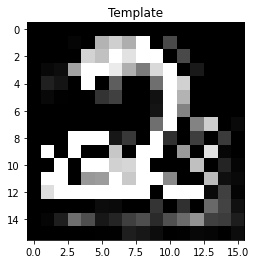

In [20]:
plt.figure()
plt.imshow(optim_template,cmap='gray')
plt.title("Template")
plt.show()

## Deformed template for each digit

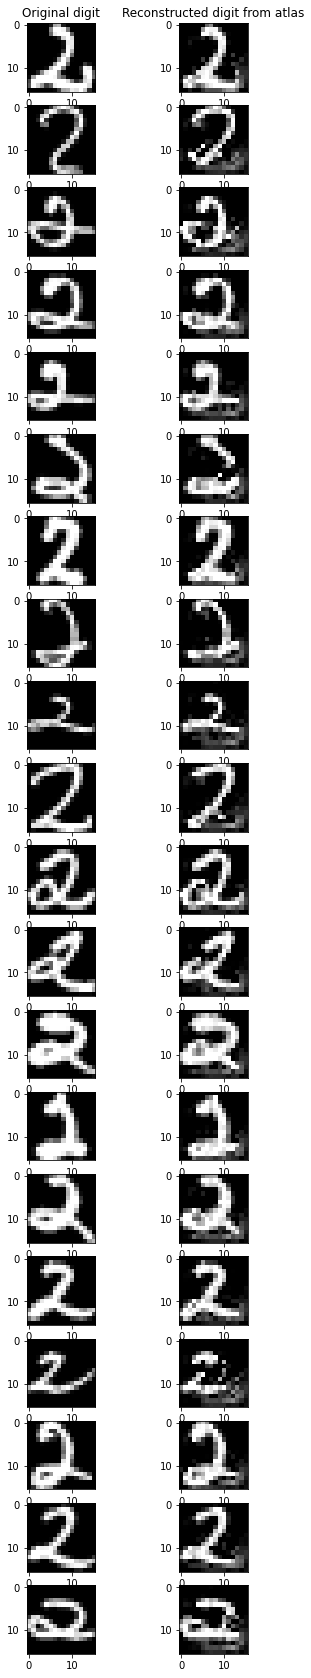

In [21]:
n_subjects = deformed_digits.shape[-1]
plt.figure(figsize=(5,30))
number_image = 1

for i in dico_images.keys():
    plt.subplot(n_subjects,2,number_image)
    plt.imshow(dico_images[i],cmap='gray')
    if i==1:
        plt.title('Original digit')

    plt.subplot(n_subjects,2,number_image+1)
    plt.imshow(deformed_digits[...,i-1],cmap='gray')
    if i==1:
        plt.title('Reconstructed digit from atlas')

    number_image += 2
plt.show()

**Play with parameters. What are their effects on the atlas estimation ?** 

1) The smaller the gamma value, the better deformation we obtain. 

2) The larger the kernel_width value, the better deformation we obtain. 

3) The larger the number of iteration, the better deformation we obtain. 

# Execution on noised images

**Add a gaussian noise to the input images.**\
In order to do this, directly modify images in dictionary `dico_images`. Or create a new dictionary with noised images.

**Execute again the atlas estimation algorithm in next cells**


**Q: What happens ?** 

We observe that for high noise levels the template is poorly estimated especially near the boundaries between the two intensity levels. It is due to the fact that high noise levels produce locations with high intensity gradients between neighboring pixels. Consequently the values at the boundaries are over estimated for the higher values and under estimated for the lower values. Therefore, noises still exist for the outcome template. 